In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sentence_transformers import SentenceTransformer

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


import matplotlib.pyplot as plt

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/processed/combined_profiles.csv")
df.head()

,age,location,ethnicity,occupation,status,description,scam,age_group,country
0,45,"New York, United states",white,engineering,divorced,"I’m balanced: secure enough to be vulnerable, ...",1,41-50,United states
1,22,"Debry, United Kingdom",mixed,self-employed,single,easygoing young girl looking for a nice partner,1,21-30,United Kingdom
2,49,"Providence, Utah, United States",white,military,divorced,I enjoy a variety of things. I am a 49 years o...,1,41-50,United States
3,48,"Castrop-Rauxel, Germany, or New York, or Los A...",white,finance,widowed,I am an optimistic person who has different in...,1,41-50,United States
4,48,"Miami, Florida, United States",white,other,widowed,"am a gentle woman, i love going to church, wil...",1,41-50,United States


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("scam", axis=1), df["scam"], test_size=0.2, random_state=42)

In [4]:
X_train

,age,location,ethnicity,occupation,status,description,age_group,country
1881,34,"Santa Marta, Magdalena, Colombia",hispanic,engineering,single,"Dark skin, light children, I'm 1.77 meters tal...",31-40,Colombia
2836,47,"Greensboro, NC, USA",white,construction,married,"I am easy going, Hard working, enjoy life",41-50,USA
4096,25,"New York, United States",black,other,single,"For beautiful eyes, look for the good in other...",21-30,United States
1173,31,"New York, United States",native american,self-employed,single,"I’m fun caring, loving and up for anything im ...",31-40,United States
3358,60,"Miami, Florida, EE. UU.",hispanic,engineering,divorced,"I am tall, white with green eyes, graying brow...",61-70,EE. UU.
...,...,...,...,...,...,...,...,...
3772,57,"St. Petersburg, FL, USA",asian,medical,single,"I am an well educated ,nice, easygoing and hap...",51-60,USA
5191,56,"Cape Town, South Africa",mixed,clerical,divorced,"I am at peace with life,with people and their ...",51-60,South Africa
5226,56,"Quito, Ecuador",hispanic,engineering,single,"Sincere, wise, intelligent, hardworking, vigor...",51-60,Ecuador
5390,50,"North Carolina, United States",white,military,widowed,I’m proud of myself in being honest and most t...,51-60,United States


# Predict with categorical features only

In [5]:
X_train_categorical = X_train.drop(["age", "location", "description"], axis=1)
X_test_categorical = X_test.drop(["age", "location", "description"], axis=1)

In [6]:
ohe = OneHotEncoder(handle_unknown="ignore")
X_train_ohe = ohe.fit_transform(X_train_categorical).toarray()
X_test_ohe = ohe.transform(X_test_categorical).toarray()

In [7]:
# fit a logistic regression model on X_train_encoded
model = LogisticRegression(max_iter=1000)
model.fit(X_train_ohe, y_train)

y_pred = model.predict(X_test_ohe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       594
           1       0.97      0.96      0.96       601

    accuracy                           0.96      1195
   macro avg       0.96      0.96      0.96      1195
weighted avg       0.97      0.96      0.96      1195



In [8]:
y_pred_proba = model.predict_proba(X_test_ohe)
# calculate softmax for y_pred_proba
y_pred_proba_softmax = np.exp(y_pred_proba) / np.sum(np.exp(y_pred_proba), axis=1)[:, None]
# extract just the probability for class = 1
y_pred_proba_class_1 = y_pred_proba_softmax[:, 1]
y_pred_proba_class_1

array([0.26940718, 0.26906604, 0.26904928, ..., 0.7256274 , 0.26949777,
       0.29504752])

In [9]:
y_pred_log_proba = model.predict_log_proba(X_test_ohe)
y_pred_log_proba_softmax = np.exp(y_pred_log_proba) / np.sum(np.exp(y_pred_log_proba), axis=1)[:, None]
y_pred_log_proba_class_1 = y_pred_log_proba_softmax[:, 1]
y_pred_log_proba_class_1

array([1.18381732e-03, 3.16858381e-04, 2.74257935e-04, ...,
       9.86274802e-01, 1.41390560e-03, 6.45030040e-02])

## Check feature importance

In [10]:
# get the weights of the model
weights = model.coef_
weights = weights[0]

In [11]:
feature_importance = pd.DataFrame(zip(ohe.get_feature_names_out(), np.transpose(model.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:10]

,features,coef
237,country_United States,5.778728
235,country_United Kingdom,3.989595
59,status_widowed,2.993118
245,country_United states,2.607001
40,occupation_military,2.296445
132,country_Ghana,2.103191
61,age_group_21-30,2.021546
211,country_Switzerland,1.833908
193,country_Russia,1.793899
79,country_Afghanistan,1.532019


In [12]:
feature_importance.sort_values(by='coef', ascending=True)[:10]

,features,coef
229,country_USA,-3.814964
107,country_Colombia,-3.220335
8,ethnicity_hispanic,-2.746336
170,country_México,-2.500166
250,country_Venezuela,-2.493120
122,country_España,-2.318460
118,country_Ecuador,-2.315278
227,country_UK,-2.282323
182,country_Perú,-2.185689
110,country_Cuba,-1.799170


In [13]:
stats = feature_importance["coef"].describe()
stats

count    277.000000
mean      -0.000025
std        0.965155
min       -3.814964
25%       -0.377871
50%        0.019035
75%        0.436513
max        5.778728
Name: coef, dtype: float64

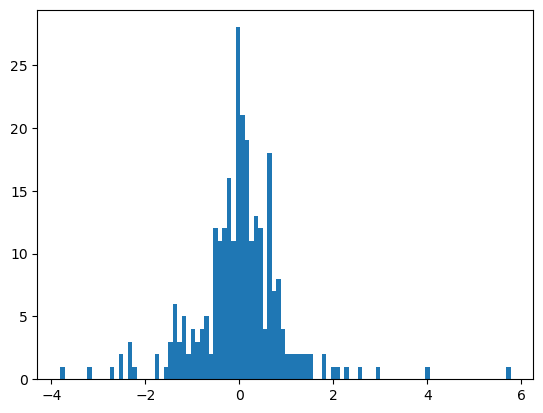

In [14]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

# Use descriptions to predict

In [15]:
X_train_desc = X_train.loc[:, "description"]
X_test_desc = X_test.loc[:, "description"]

## BoW feature engineering

In [16]:
# perform BoW on the description
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train_desc)
X_test_bow = vectorizer.transform(X_test_desc)

In [17]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       594
           1       0.86      0.84      0.85       601

    accuracy                           0.85      1195
   macro avg       0.85      0.85      0.85      1195
weighted avg       0.85      0.85      0.85      1195



In [18]:
# add other n-grams
BOW_vectorizer = CountVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))
X_train_bow = BOW_vectorizer.fit_transform(X_train_desc)
X_test_bow = BOW_vectorizer.transform(X_test_desc)

In [19]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       594
           1       0.88      0.84      0.86       601

    accuracy                           0.86      1195
   macro avg       0.86      0.86      0.86      1195
weighted avg       0.86      0.86      0.86      1195



In [20]:
feature_importance = pd.DataFrame(zip(BOW_vectorizer.get_feature_names_out(), np.transpose(model.coef_).flatten()), columns=['features', 'coef']) 
feature_importance.sort_values(by='coef', ascending=False)[:10]

,features,coef
22584,com,3.042688
26617,cool,2.195960
18194,caring,2.116556
105142,name,1.576759
152495,tell,1.523734
95406,man,1.330127
174173,yahoo,1.329244
139295,simple fun,1.249818
92218,lovely,1.176169
43883,fearing,1.105949


In [21]:
feature_importance.sort_values(by='coef', ascending=True)[:10]

,features,coef
172193,worker,-1.073381
171144,women,-0.933286
3427,affectionate,-0.898031
104238,music,-0.890586
158101,travel,-0.843613
169381,without,-0.818560
163176,values,-0.785818
25129,consider,-0.760966
165713,wants,-0.732995
63935,hi,-0.728530


coefs represent the average change in the _log_ odds of the response variable associated with a one unit increase in the predictor variable. [see here](https://www.statology.org/interpret-logistic-regression-coefficients/)

In [22]:
stats = feature_importance["coef"].describe()
stats

count    175322.000000
mean          0.000761
std           0.052046
min          -1.073381
25%          -0.010348
50%           0.000046
75%           0.010727
max           3.042688
Name: coef, dtype: float64

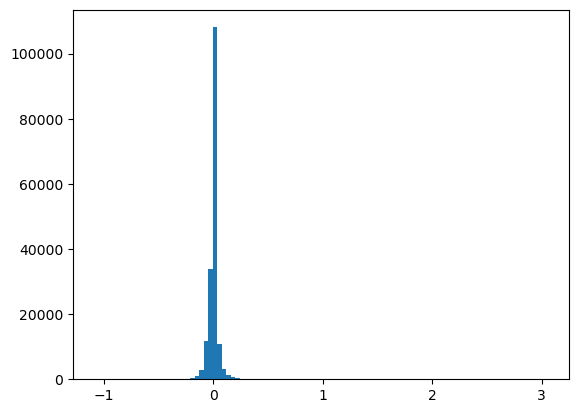

In [23]:
plt.hist(feature_importance["coef"], bins=100)
plt.show()

In [24]:
# get outliers using Tukey's method
iqr = stats["75%"] - stats["25%"]
k = 3
outliers = feature_importance[(feature_importance["coef"] < stats["25%"] - iqr * k) | (feature_importance["coef"] > stats["75%"] + iqr * k)]
outliers

,features,coef
17,10,-0.180511
26,10 languages,-0.136680
27,10 languages confident,-0.136680
43,100,-0.187553
50,100 family,-0.093544
...,...,...
175217,yr,-0.192148
175218,yr old,-0.192148
175220,yr old daughter,-0.095042
175223,yr old looking,0.077789


## Use TF-IDF

In [25]:
# perform tf-idf on the description
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords.words("english"), ngram_range=(1,3))
X_train_tfidf = tf_idf_vectorizer.fit_transform(X_train_desc)
X_test_tfidf = tf_idf_vectorizer.transform(X_test_desc)

In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82       594
           1       0.78      0.93      0.85       601

    accuracy                           0.83      1195
   macro avg       0.85      0.83      0.83      1195
weighted avg       0.85      0.83      0.83      1195



# Use sentence embeddings

In [27]:
sbert = SentenceTransformer("all-MiniLM-L6-v2")

In [28]:
X_train_encoded = X_train_desc.apply(lambda x: sbert.encode(x))
X_train_encoded = np.array(X_train_encoded.tolist())
X_train_encoded

array([[ 0.01210405,  0.03400637,  0.09418543, ..., -0.03186187,
        -0.11362939, -0.02503378],
       [-0.00232225, -0.03443858,  0.04442555, ...,  0.03976387,
         0.00305107, -0.03309342],
       [ 0.01972021, -0.04182891,  0.04288832, ...,  0.06683129,
        -0.05454608, -0.06358099],
       ...,
       [-0.02086444, -0.07659955,  0.08812441, ..., -0.01896485,
         0.0178203 , -0.03107213],
       [-0.03885498, -0.03188643,  0.03777167, ...,  0.04280732,
        -0.04428764, -0.0502914 ],
       [ 0.02076072, -0.11315738,  0.02563138, ..., -0.12051469,
         0.02833179, -0.04110634]], dtype=float32)

In [29]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(X_train_encoded)
pca_2.explained_variance_ratio_

array([0.07327034, 0.05979143], dtype=float32)

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 2} Score 0.050353635


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 3} Score 0.042009883


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 4} Score 0.04405919


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 5} Score 0.03236588


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 10} Score 0.017620573


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 15} Score 0.012764523


/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Parameter: {'n_clusters': 20} Score 0.010081941


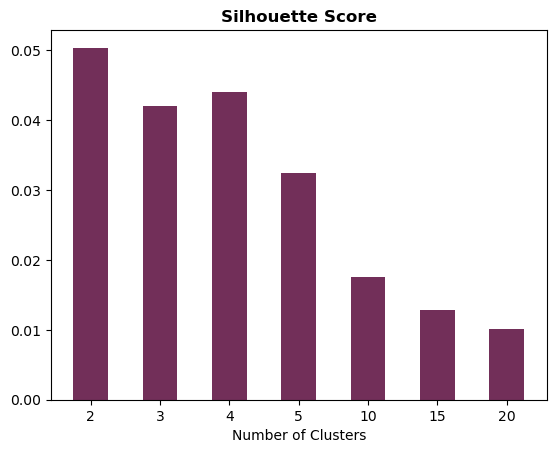

In [30]:
n_clusters = [2, 3, 4, 5, 10, 15, 20]
parameter_grid = [{"n_clusters": i} for i in n_clusters]

best_score = -1
kmeans_model = KMeans(n_clusters=2, random_state=42)     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(X_train_encoded)          
    ss = silhouette_score(X_train_encoded, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        optimal_n_clusters = p["n_clusters"]
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(n_clusters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=optimal_n_clusters)
kmeans.fit(X_train_encoded)
X_train_clusters = kmeans.labels_

/home/javier/miniconda3/envs/dsa4263/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


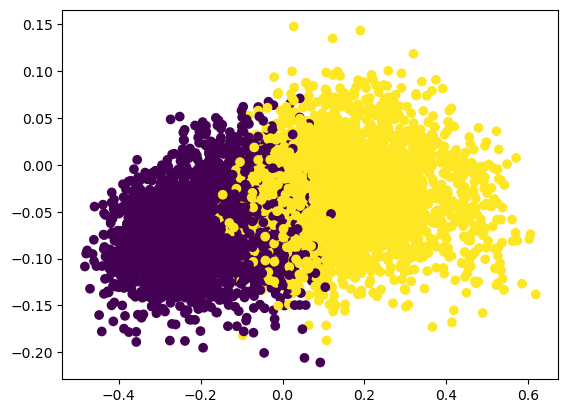

In [32]:
# plot the clusters
plt.scatter(pca_2_result[:, 0], X_train_encoded[:, 1], c=kmeans.labels_, cmap='viridis')
plt.show()

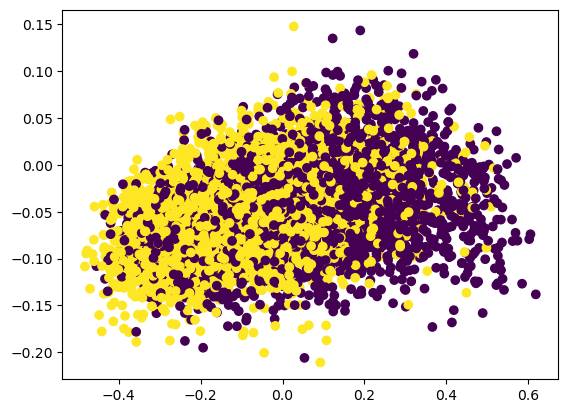

In [33]:
# plot the clusters with real labels
plt.scatter(pca_2_result[:, 0], X_train_encoded[:, 1], c=y_train, cmap='viridis')
plt.show()

## Add cluster label of sentence embedding of description as feature

In [42]:
X_test_encoded = X_test_desc.apply(lambda x: sbert.encode(x))
X_test_encoded = np.array(X_test_encoded.tolist())
X_test_encoded

array([[-0.05006866, -0.03208937,  0.03466472, ..., -0.02548538,
        -0.04454817, -0.06812955],
       [ 0.02250776, -0.01535878,  0.07246874, ..., -0.03836347,
        -0.02807825, -0.00927844],
       [-0.06787971,  0.01939736,  0.05201722, ..., -0.00646068,
        -0.0030451 , -0.01696373],
       ...,
       [-0.00406187, -0.09989465,  0.02330182, ..., -0.06938202,
        -0.06361845, -0.01848407],
       [ 0.08393799, -0.03721001,  0.02225354, ..., -0.02970402,
        -0.03350262, -0.01616038],
       [ 0.06563657, -0.04033625,  0.04672479, ...,  0.03452814,
         0.00500236, -0.10461781]], dtype=float32)

In [43]:
X_test_clusters = kmeans.predict(X_test_encoded)

### Check accuracy of cluster

In [63]:
print(classification_report(y_test, X_test_clusters))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62       594
           1       0.62      0.56      0.59       601

    accuracy                           0.61      1195
   macro avg       0.61      0.61      0.60      1195
weighted avg       0.61      0.61      0.60      1195



In [59]:
# combine X_train_ohe and X_train_clusters
X_train_combined = np.hstack((X_train_ohe, X_train_clusters.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_ohe, X_test_clusters.reshape(-1, 1)))

In [60]:
# fit a logistic regression model on X_train_encoded
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       594
           1       0.97      0.95      0.96       601

    accuracy                           0.96      1195
   macro avg       0.96      0.96      0.96      1195
weighted avg       0.96      0.96      0.96      1195

